<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221029_porto_driver_Assert_LightGBM_Feval_OOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 안전 운전자 예측
 - 고객 데이터 활용하여, 운전자가 보험을 청구할 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : 정규화된 지니계수
 - 사용모델 : LightGBM와 XGBoost의 앙상블

In [2]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

### 피처 엔지니어링

#### 데이터 합치기 
 - 훈련, 테스트 데이터에 동일한 인코딩을 적용하기 위해
 - 인코딩은 타깃값이 아닌 피처에만 적용

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

In [4]:
all_features = all_data.columns # 전체 피처명 리스트
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

# 명목형 피처 원-핫 인코딩
 - 명목형 데이터에는 고유값별 순서가 따로 없으므로 원-핫 인코딩

In [5]:
from sklearn.preprocessing import OneHotEncoder

# 방법1. 지능형 리스트(list comprehension) + 조건문
cat_features = [feature for feature in all_features if 'cat' in feature] # 리스트 컴프리헨션(+ 조건문)


# 방법2. 빈리스트 초기화 → 반복문+조건문 → 빈리스트.append
list_comprehension = []
for feature in all_features:
    if 'cat' in feature:
        list_comprehension.append(feature)

onehot_encoder = OneHotEncoder() # 인코더 객체 생성

encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

#### 필요 없는 피처 제거

In [6]:
# 추가 제거할 피처 목록
drop_features = ['ps_ind_14','ps_ind_10_bin','ps_ind_11_bin',
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14']

# 남길 피처 : (1.명목형 피처, 2.calc분류의 피처, 3.'추가 제거할 피처')를 제외한 피처
remaining_features = [feature for feature in all_features
                                if ('cat' not in feature and        # if조건문에 여러 조건을 쓰려면 → if(A조건 and B조건 and C조건)
                                    'calc' not in feature and       # List Comprehension내 조건문에는 ':' 사용하지 않는다
                                    feature not in drop_features)]

 - 원-핫 인코딩된 명목형 데이터(=CSR matrix format)
 - remaining_features에 해당하는 데이터(=DataFrame)

 - 상기의 두 데이터(CSR, DataFrame)을 합쳐서 CSR형식으로 만들자

  > sparse.hstack() : CSR을 다룰수 있는 데이터 병합 메서드

  > sparse.csr_matrix() : 전달받은 데이터를 CSR형식으로 바꿔줌

In [7]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]), # DataFrame → CSR
                               encoded_cat_matrix], # CSR
                              format='csr') # 합친후 CSR형식으로 반환

#### 데이터 나누기
 - 합쳐서 인코딩 및 피처제거 완료 후 나누기
 - 타깃값도 y에 할당

In [8]:
num_train = len(train)

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

# all_data로 데이터를 합칠때부터 target은 drop했으므로, train데이터에서 target가져옴
y = train['target'].values # Series.values : array

### 평가지표 계산 함수 작성
 - 평가지표 계산 함수

  > 대회에서 주어지는것은 훈련 데이터셋과 테스트 데이터(타깃값X)

  > 타깃값이 존재하는 훈련 데이터 셋만으로 모델에 대한 평가가 필요함(모델을 평가하기 위해서는 타깃값이 필요하므로)

  > 훈련 데이터셋을 일부 떼어내어 검증 데이터셋을 만들어서 정답을 숨겼다가 모델의 성능을 평가해봄


 - 본 경진대회의 평가지표는 정규화된 지니계수(파이썬,사이킷런에서 제공X)

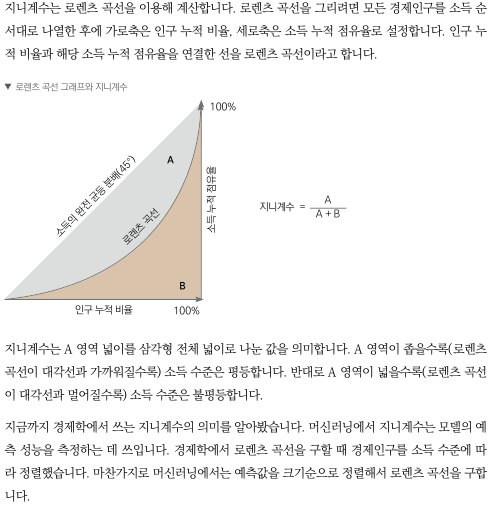

 - 로렌츠 곡선 상단 넓이를 삼각형 넓이로 나눈 값 : 지니계수

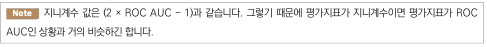

#### 정규화된 지니계수 계산 함수
 - 지니계수 값을 0~1사이로 조정(0:성능나쁨, 1:성능좋음)

 - 일반적인 정규화

  > 데이터의 전체 범위에 대한 해당데이터의 위치

 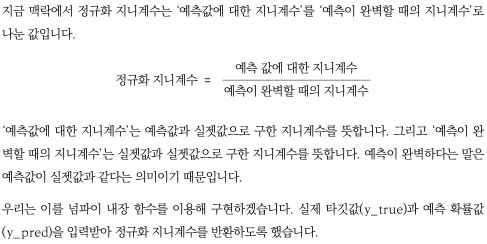

In [10]:
import numpy as np

# '실제값'과 '예측값'을 입력받아 정규화된 지니계수 반환하는 함수
def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape # 가정설정문 assert 사용법 : assert 조건, '메시지'(생략가능)
    
    n_samples = y_true.shape[0] # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # np.linspace(0, 1, N) : 0에서 1사이값으로 N개 데이터 배열

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred.argsort() : y_pred의 오름차순 인덱스
    # 로렌츠 곡선
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # cumsum([1,2,3]) : [1,3,6] 각 원소의 누적 합
    # 예측값에 대한 지니계수
    G_pred = np.sum(L_mid - L_pred)

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true크기 순으로 y_true값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true) # 예측이 완벽할 때 지니계수

    # 정규화 된 지니계수
    return G_pred / G_true

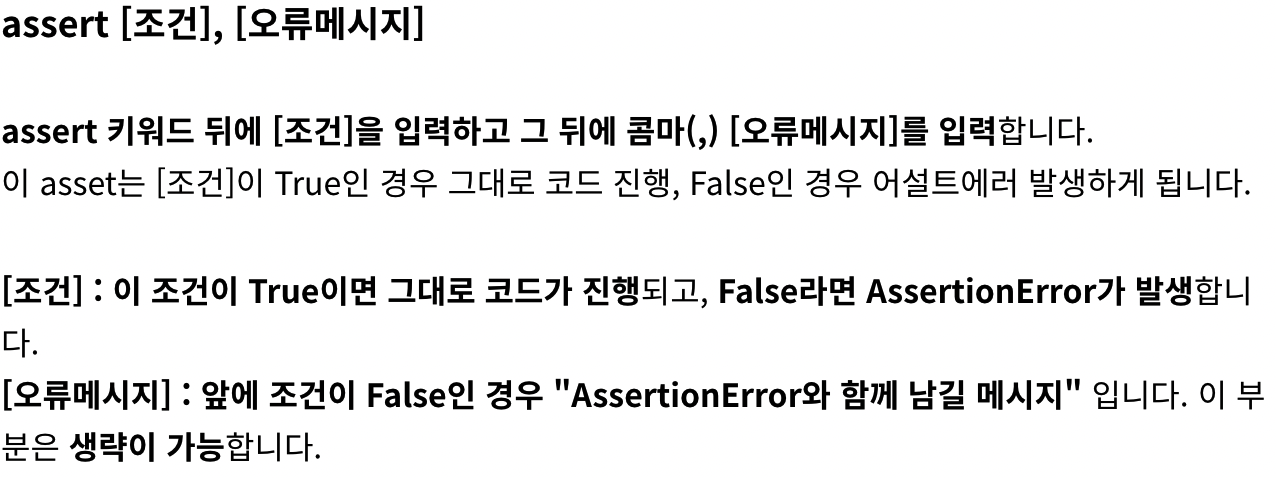

In [9]:
# np.argsort : 배열의 값에 대해 숫자크기순(오름차순) 인덱스 반환
a = np.array([1.5, 0.2, 4.2, 2.5])
s = a.argsort()

print(s)
print(a[s])

[1 0 3 2]
[0.2 1.5 2.5 4.2]


In [ ]:
# LightGBM모델 훈련시 검증 파라미터에 전달할 "자체제작 gini() 함수"
def gini(preds, dtrain):
    labels = dtrain.get_label() # dtrain.get_label() : dtrain의 타깃값을 반환
    return 'gini', eval_gini(labels, preds), True # 반환값 3가지 필요 : '평가지표이름', '평가 점수 반환하는 함수', '평가 점수가 높을수록 좋은지 여부'

### 모델 훈련 및 성능 검증


#### OOF 예측 방식
 - 캐글에서 자주 사용하는 예측 기법

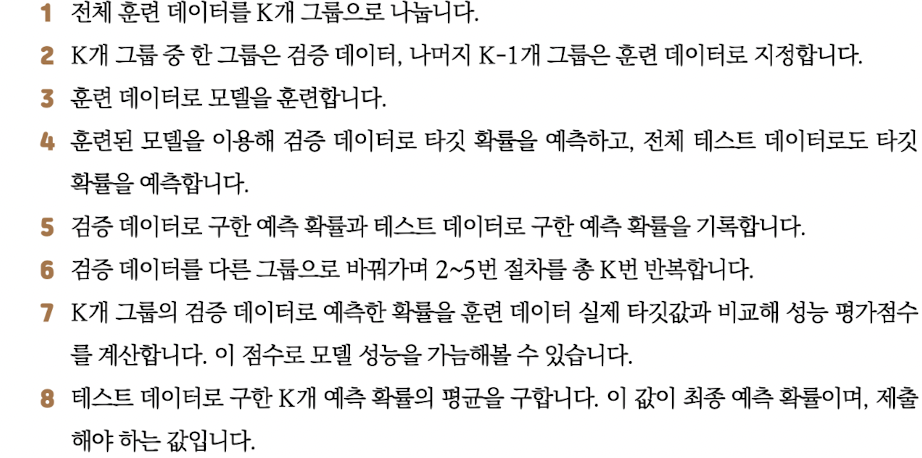

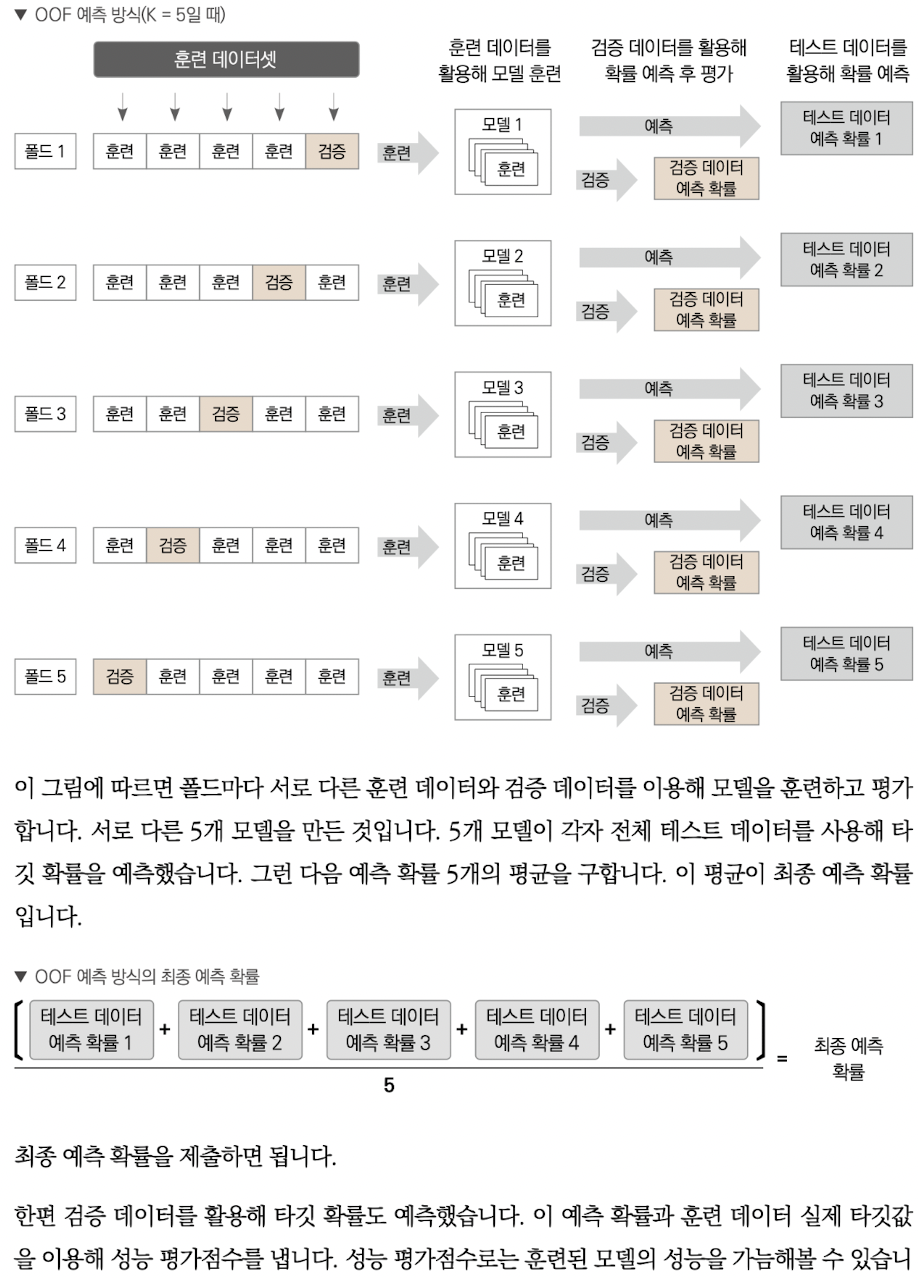

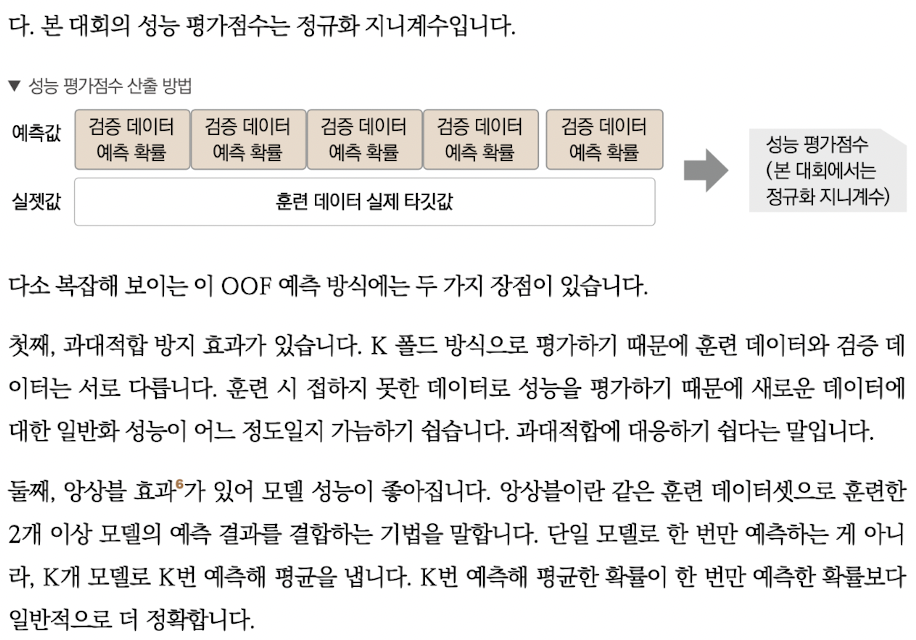

#### OOF 방식으로 LightGBM 훈련
 - OOF 방식으로 사용할 모델은 LightGBM 사용

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
